<a href="https://colab.research.google.com/github/kursatkara/MAE_5020_S24/blob/master/05_08_PyDMD_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PyDMD**
This notebook is based on the tutorial of PyDMD.
(https://pydmd.github.io/PyDMD/)

 "PyDMD is a Python package designed for Dynamic Mode Decomposition (DMD), a data-driven method used for analyzing and extracting spatiotemporal coherent structures from time-varying datasets. It provides a comprehensive and user-friendly interface for performing DMD analysis, making it a valuable tool for researchers, engineers, and data scientists working in various fields."


In [1]:
try:
    # Try importing the pydmd module
    import pydmd
    print("PyDMD is already installed.")
except ImportError:
    # If the import fails, install the pydmd package
    print("PyDMD is not installed. Installing now...")
    !pip install pydmd
    # Import pydmd after installation
    import pydmd
    print("PyDMD has been successfully installed.")


PyDMD is already installed.


In [2]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

from pydmd import DMD, BOPDMD
from pydmd.plotter import plot_eigs, plot_summary
from pydmd.preprocessing import hankel_preprocessing

In [3]:
# We create the input data by summing two different functions:
def f1(x, t):
    return 1.0 / np.cosh(x + 3) * np.cos(2.3 * t)

def f2(x, t):
    return 2.0 / np.cosh(x) * np.tanh(x) * np.sin(2.8 * t)


nx = 65  # number of grid points along space dimension
nt = 129  # number of grid points along time dimension

# Define the space and time grid for data collection.
x = np.linspace(-5, 5, nx)
t = np.linspace(0, 4 * np.pi, nt)
xgrid, tgrid = np.meshgrid(x, t)
dt = t[1] - t[0]  # time step between each snapshot

# Data consists of 2 spatiotemporal signals.
X1 = f1(xgrid, tgrid)
X2 = f2(xgrid, tgrid)
X = X1 + X2

# Make a version of the data with noise.
mean = 0
std_dev = 0.2
random_matrix = np.random.normal(mean, std_dev, size=(nt, nx))
Xn = X + random_matrix

X.shape

(129, 65)

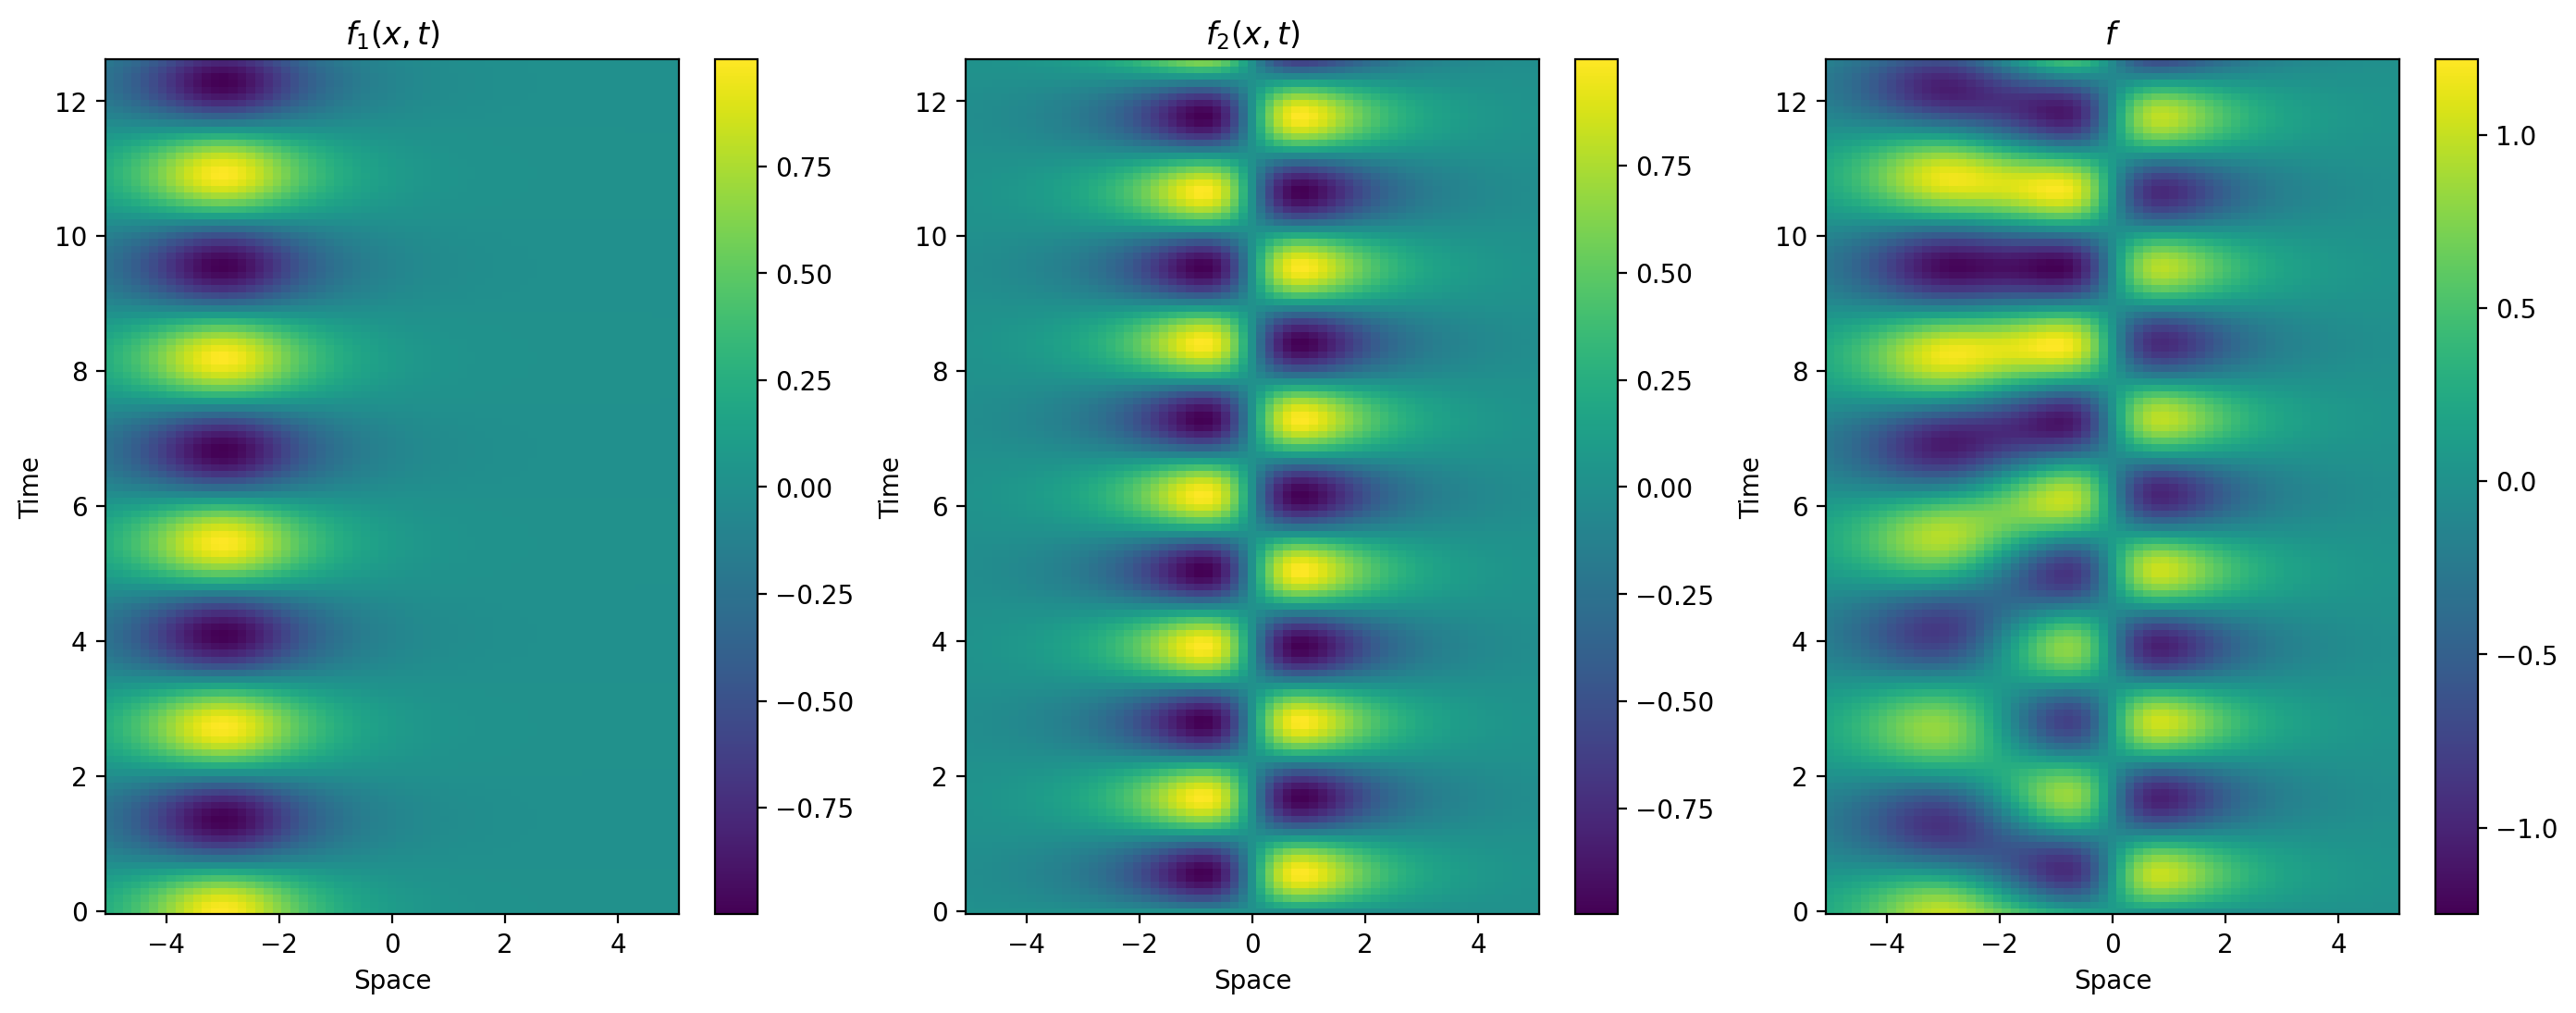

In [4]:
# The plots below represent these functions and the dataset without noise.
titles = ["$f_1(x,t)$", "$f_2(x,t)$", "$f$"]
data = [X1, X2, X]

fig = plt.figure(figsize=(17, 6), dpi=200)
for n, title, d in zip(range(131, 134), titles, data):
    plt.subplot(n)
    plt.pcolor(xgrid, tgrid, d.real)
    plt.title(title)
    plt.xlabel("Space")
    plt.ylabel("Time")
    plt.colorbar()
plt.show()

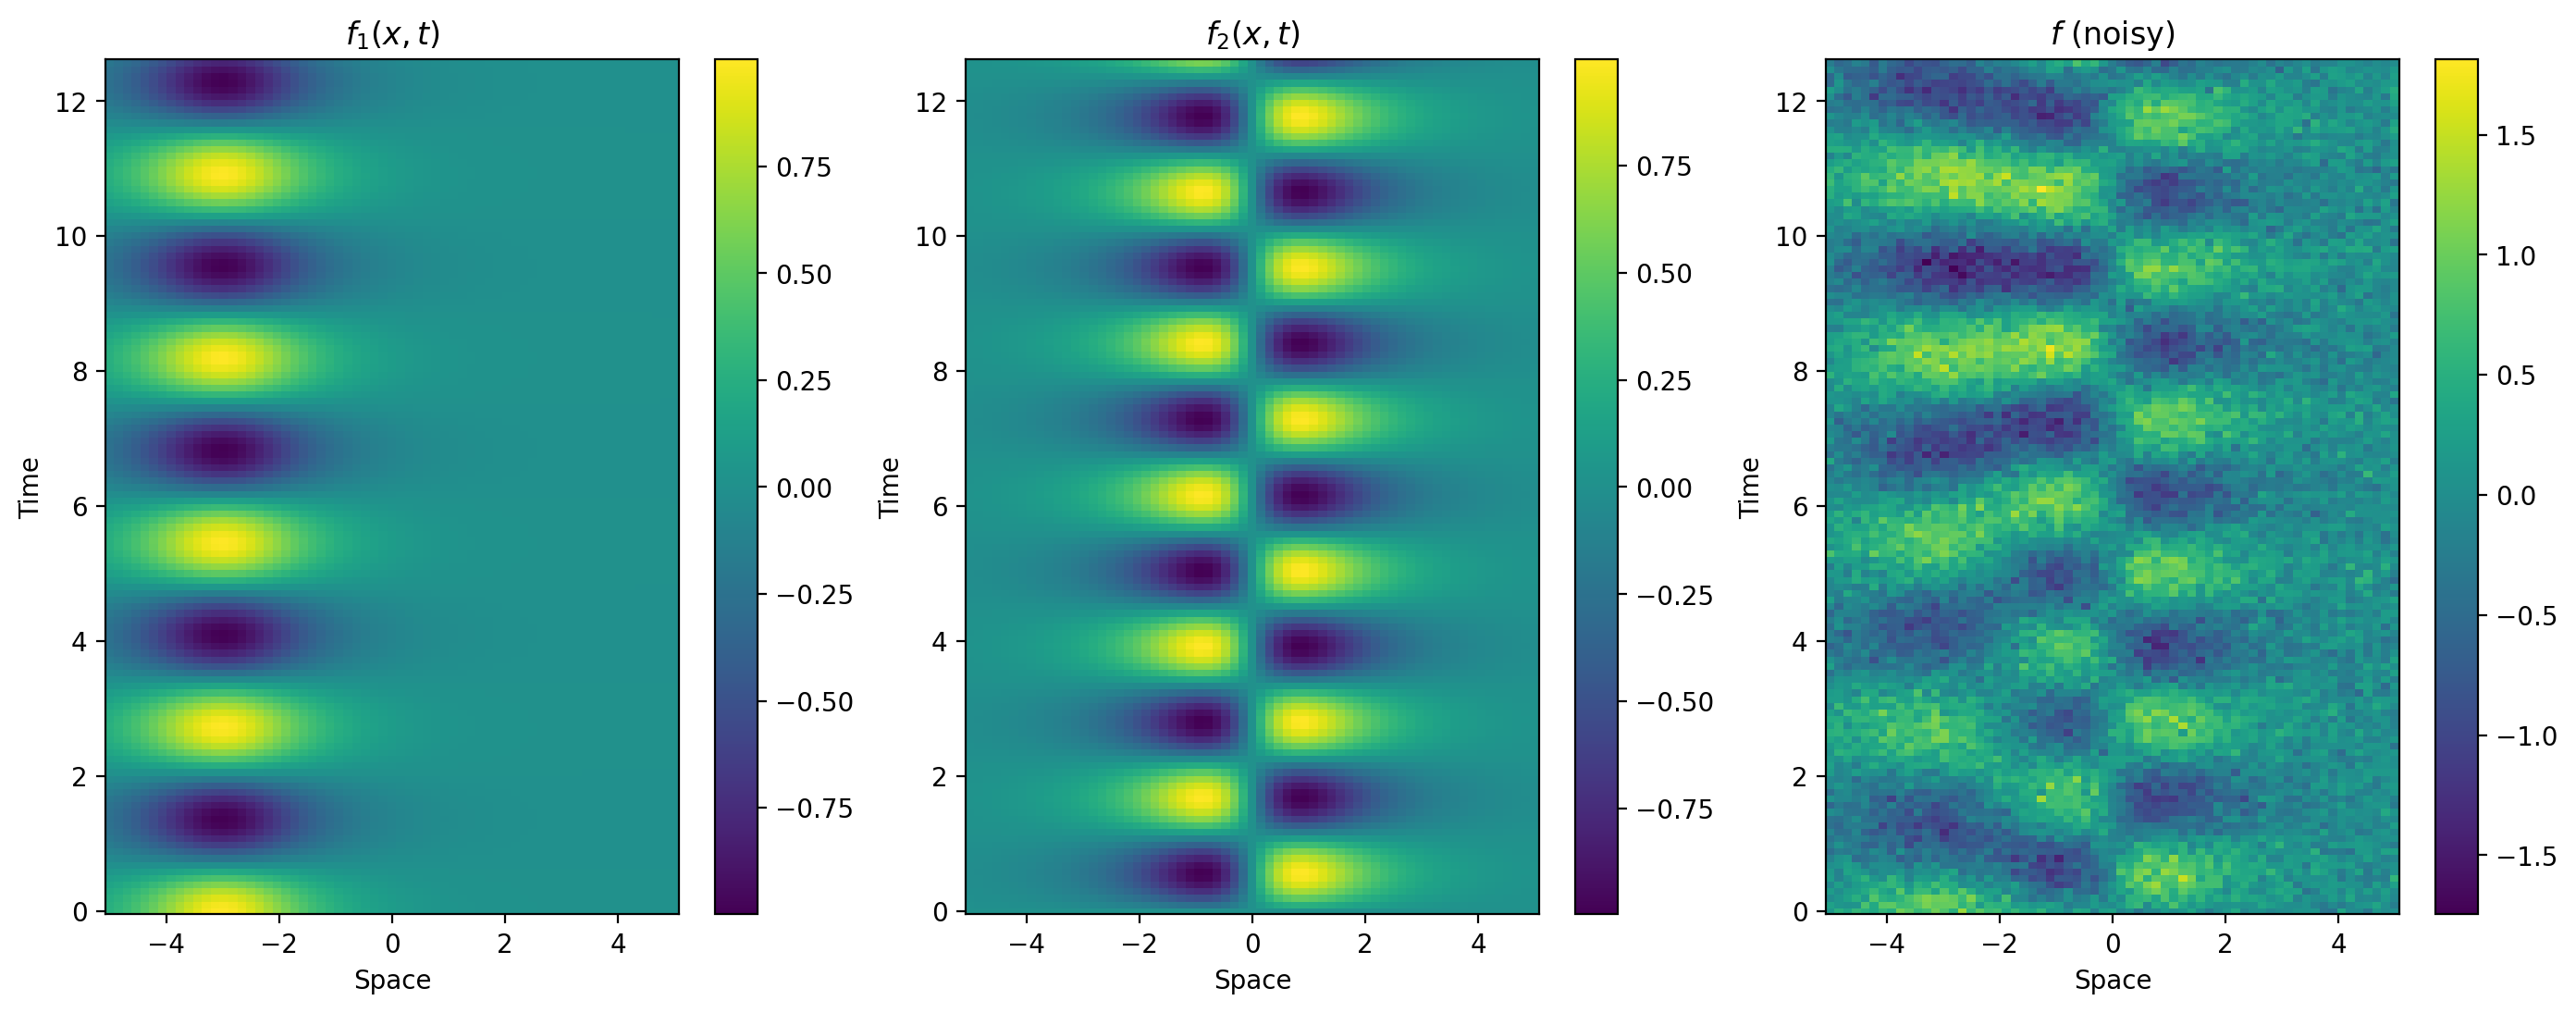

In [5]:
# The plots below represent these functions and the dataset with noise.
titles = ["$f_1(x,t)$", "$f_2(x,t)$", "$f$ (noisy)"]
data = [X1, X2, Xn]

fig = plt.figure(figsize=(17, 6), dpi=200)
for n, title, d in zip(range(131, 134), titles, data):
    plt.subplot(n)
    plt.pcolor(xgrid, tgrid, d.real)
    plt.title(title)
    plt.xlabel("Space")
    plt.ylabel("Time")
    plt.colorbar()
plt.show()

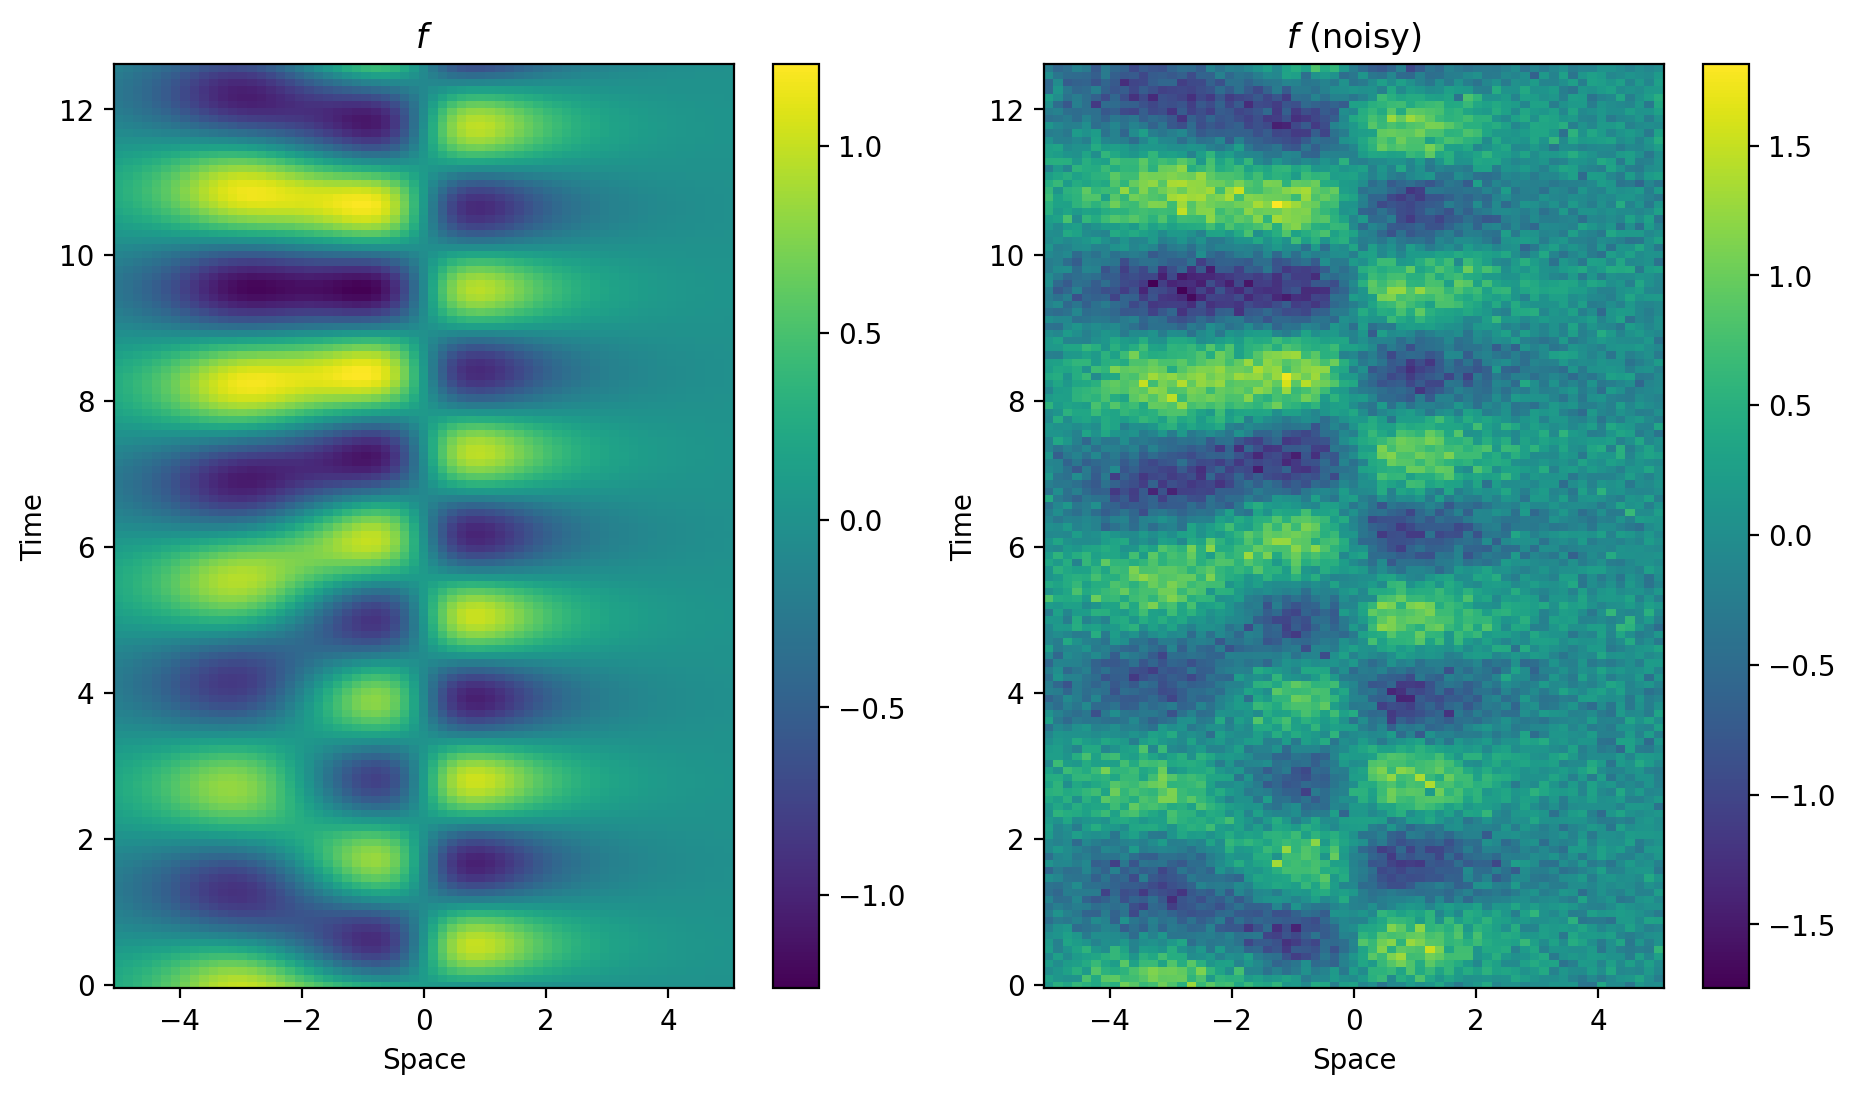

In [6]:
titles = ["$f$", "$f$ (noisy)"]
data = [X, Xn]

fig = plt.figure(figsize=(11,6), dpi=200)
for n, title, d in zip(range(121, 123), titles, data):
    plt.subplot(n)
    plt.pcolor(xgrid, tgrid, d.real)
    plt.title(title)
    plt.xlabel("Space")
    plt.ylabel("Time")
    plt.colorbar()
plt.show()

#**DMD with perfect data (i.e. clean simulation data)**


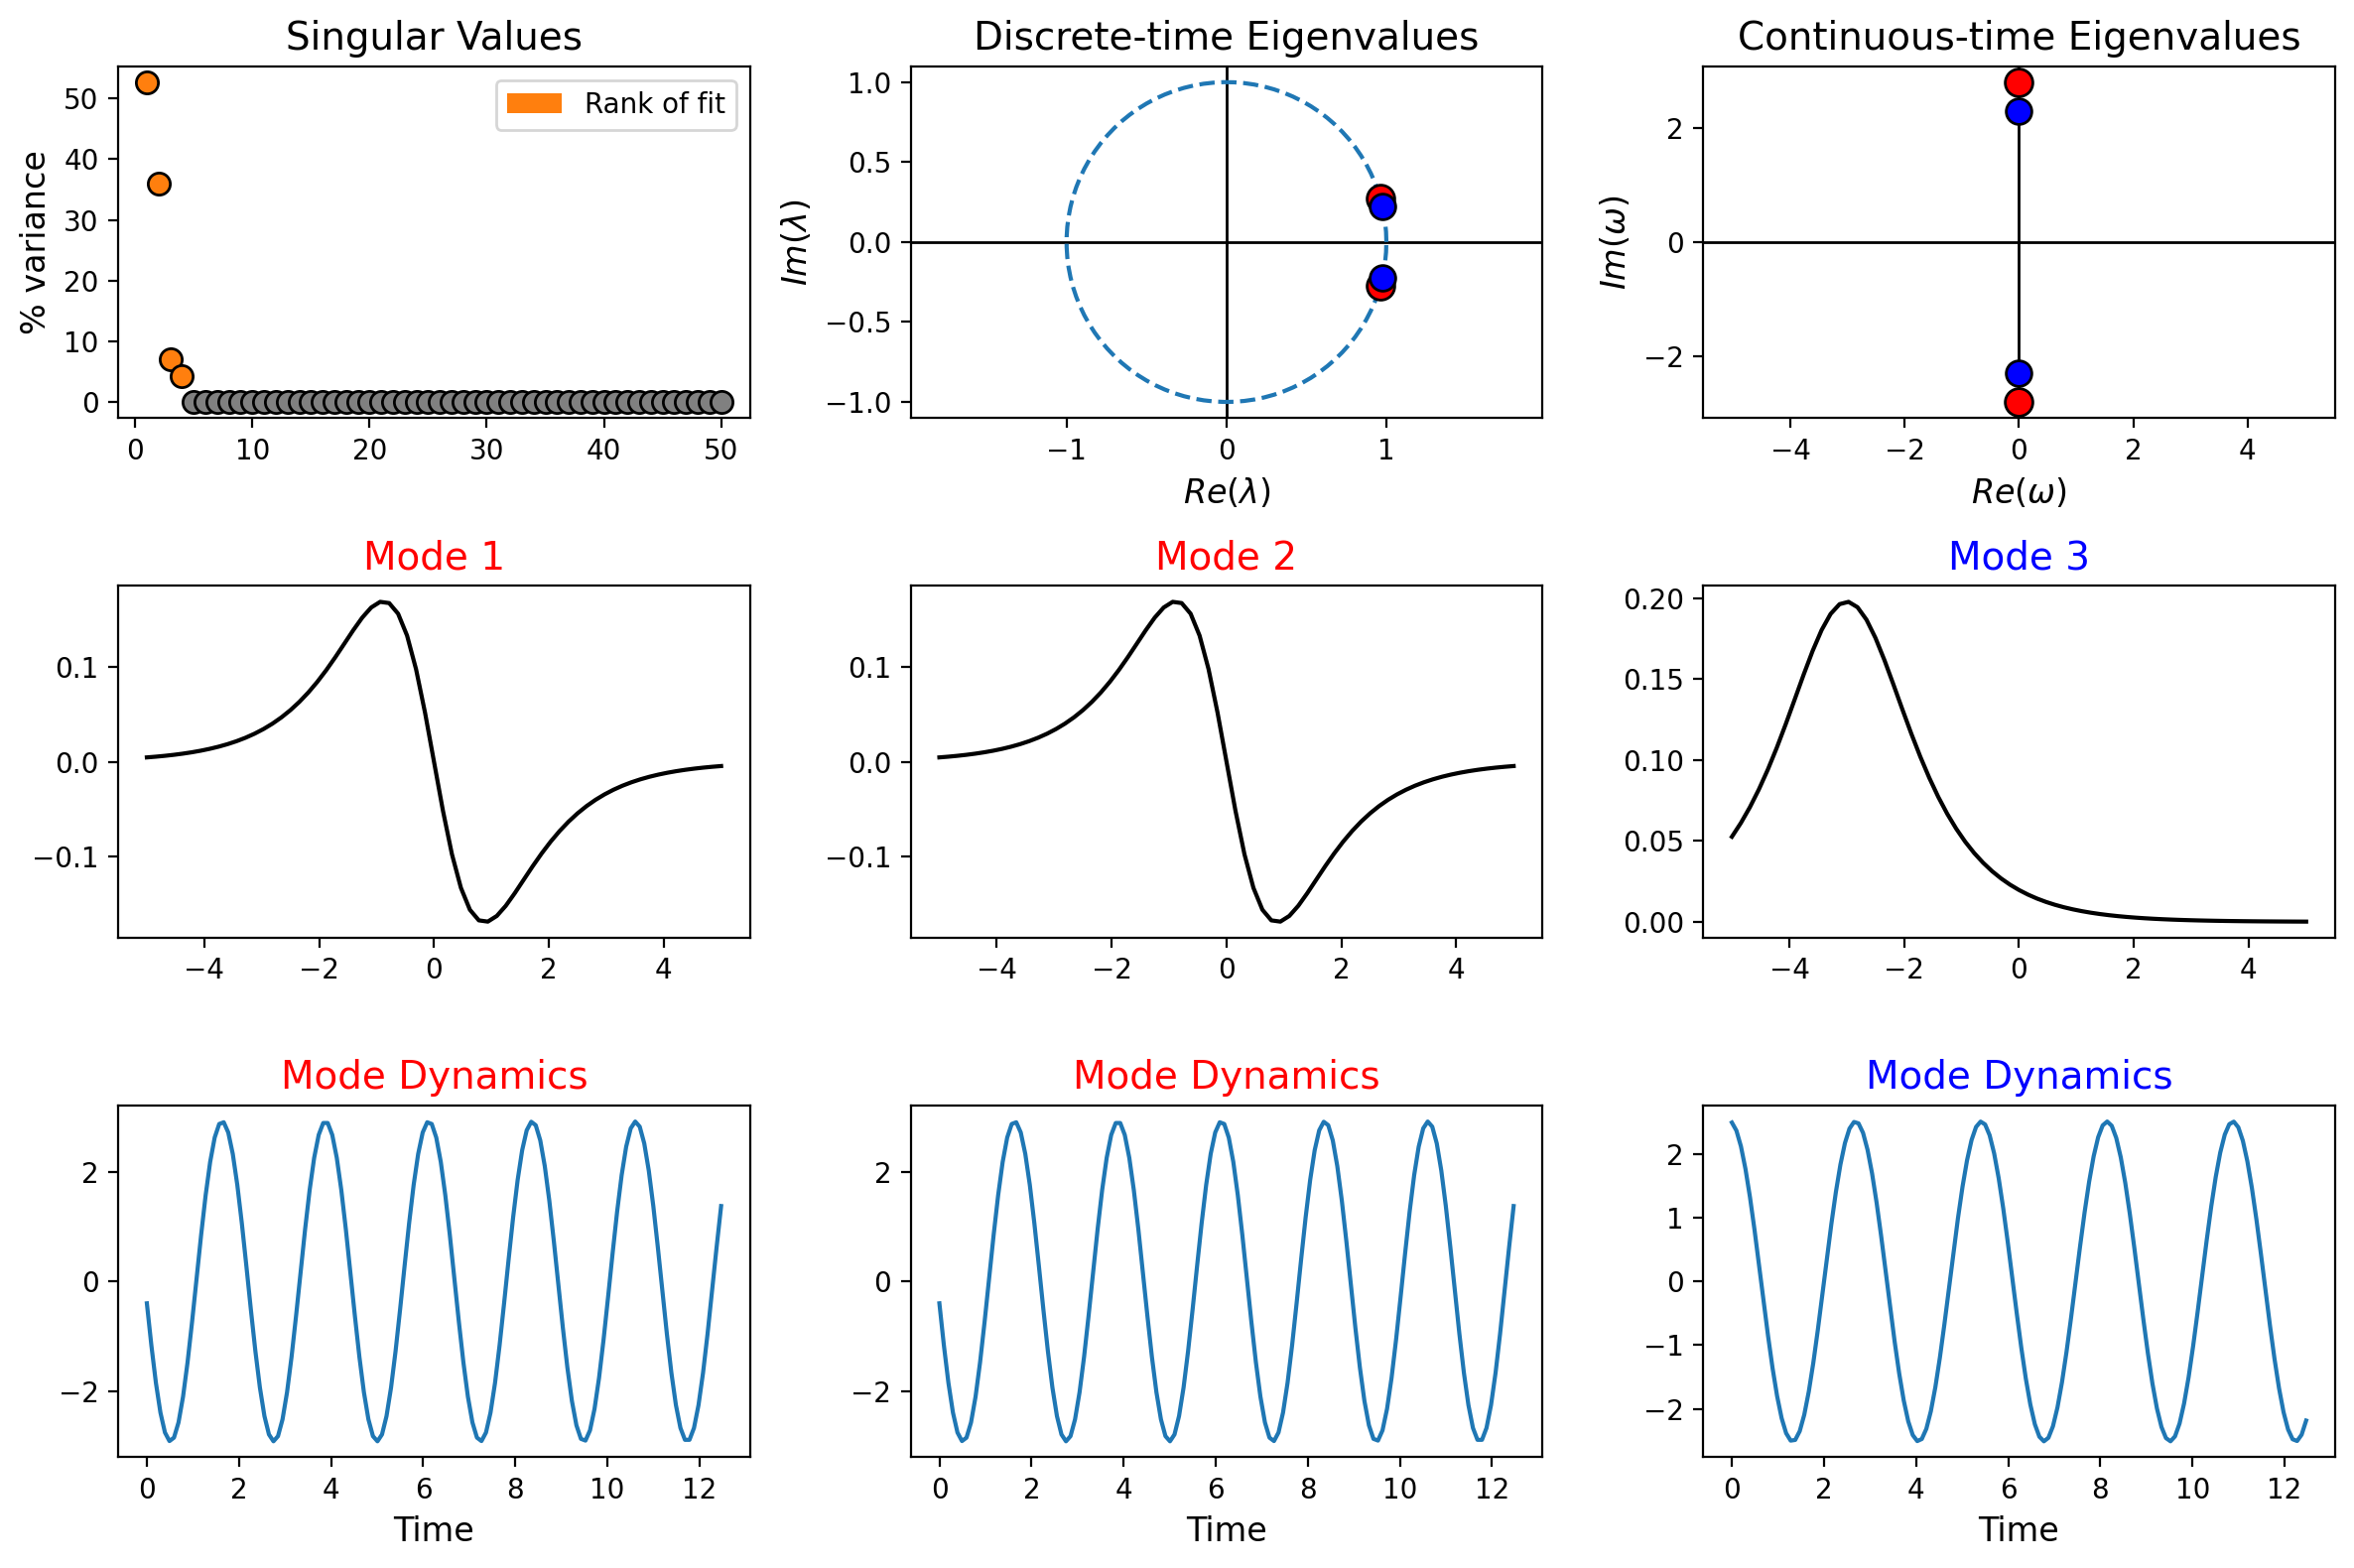

Frequencies (imaginary component): [ 0.+2.8j  0.-2.8j -0.+2.3j -0.-2.3j]


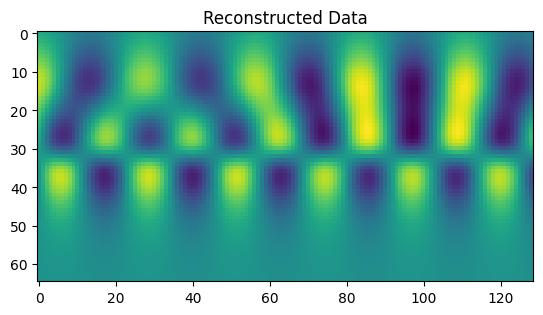

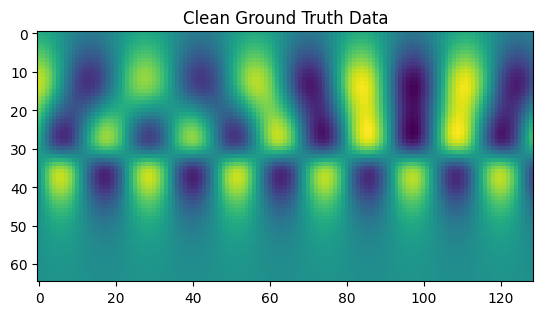

In [7]:
d = 2  # we will use this number of delays throughout the tutorial
dmd = DMD(svd_rank=4)
delay_dmd = hankel_preprocessing(dmd, d=d)
delay_dmd.fit(X.T)
plot_summary(delay_dmd, x=x, t=dt, d=d)
print(
    f"Frequencies (imaginary component): {np.round(np.log(delay_dmd.eigs) / dt, decimals=12)}"
)
plt.title("Reconstructed Data")
plt.imshow(delay_dmd.reconstructed_data.real)
plt.show()
plt.title("Clean Ground Truth Data")
plt.imshow(X.T)
plt.show()

#**DMD steps for handling real data (i.e. data with noise)**


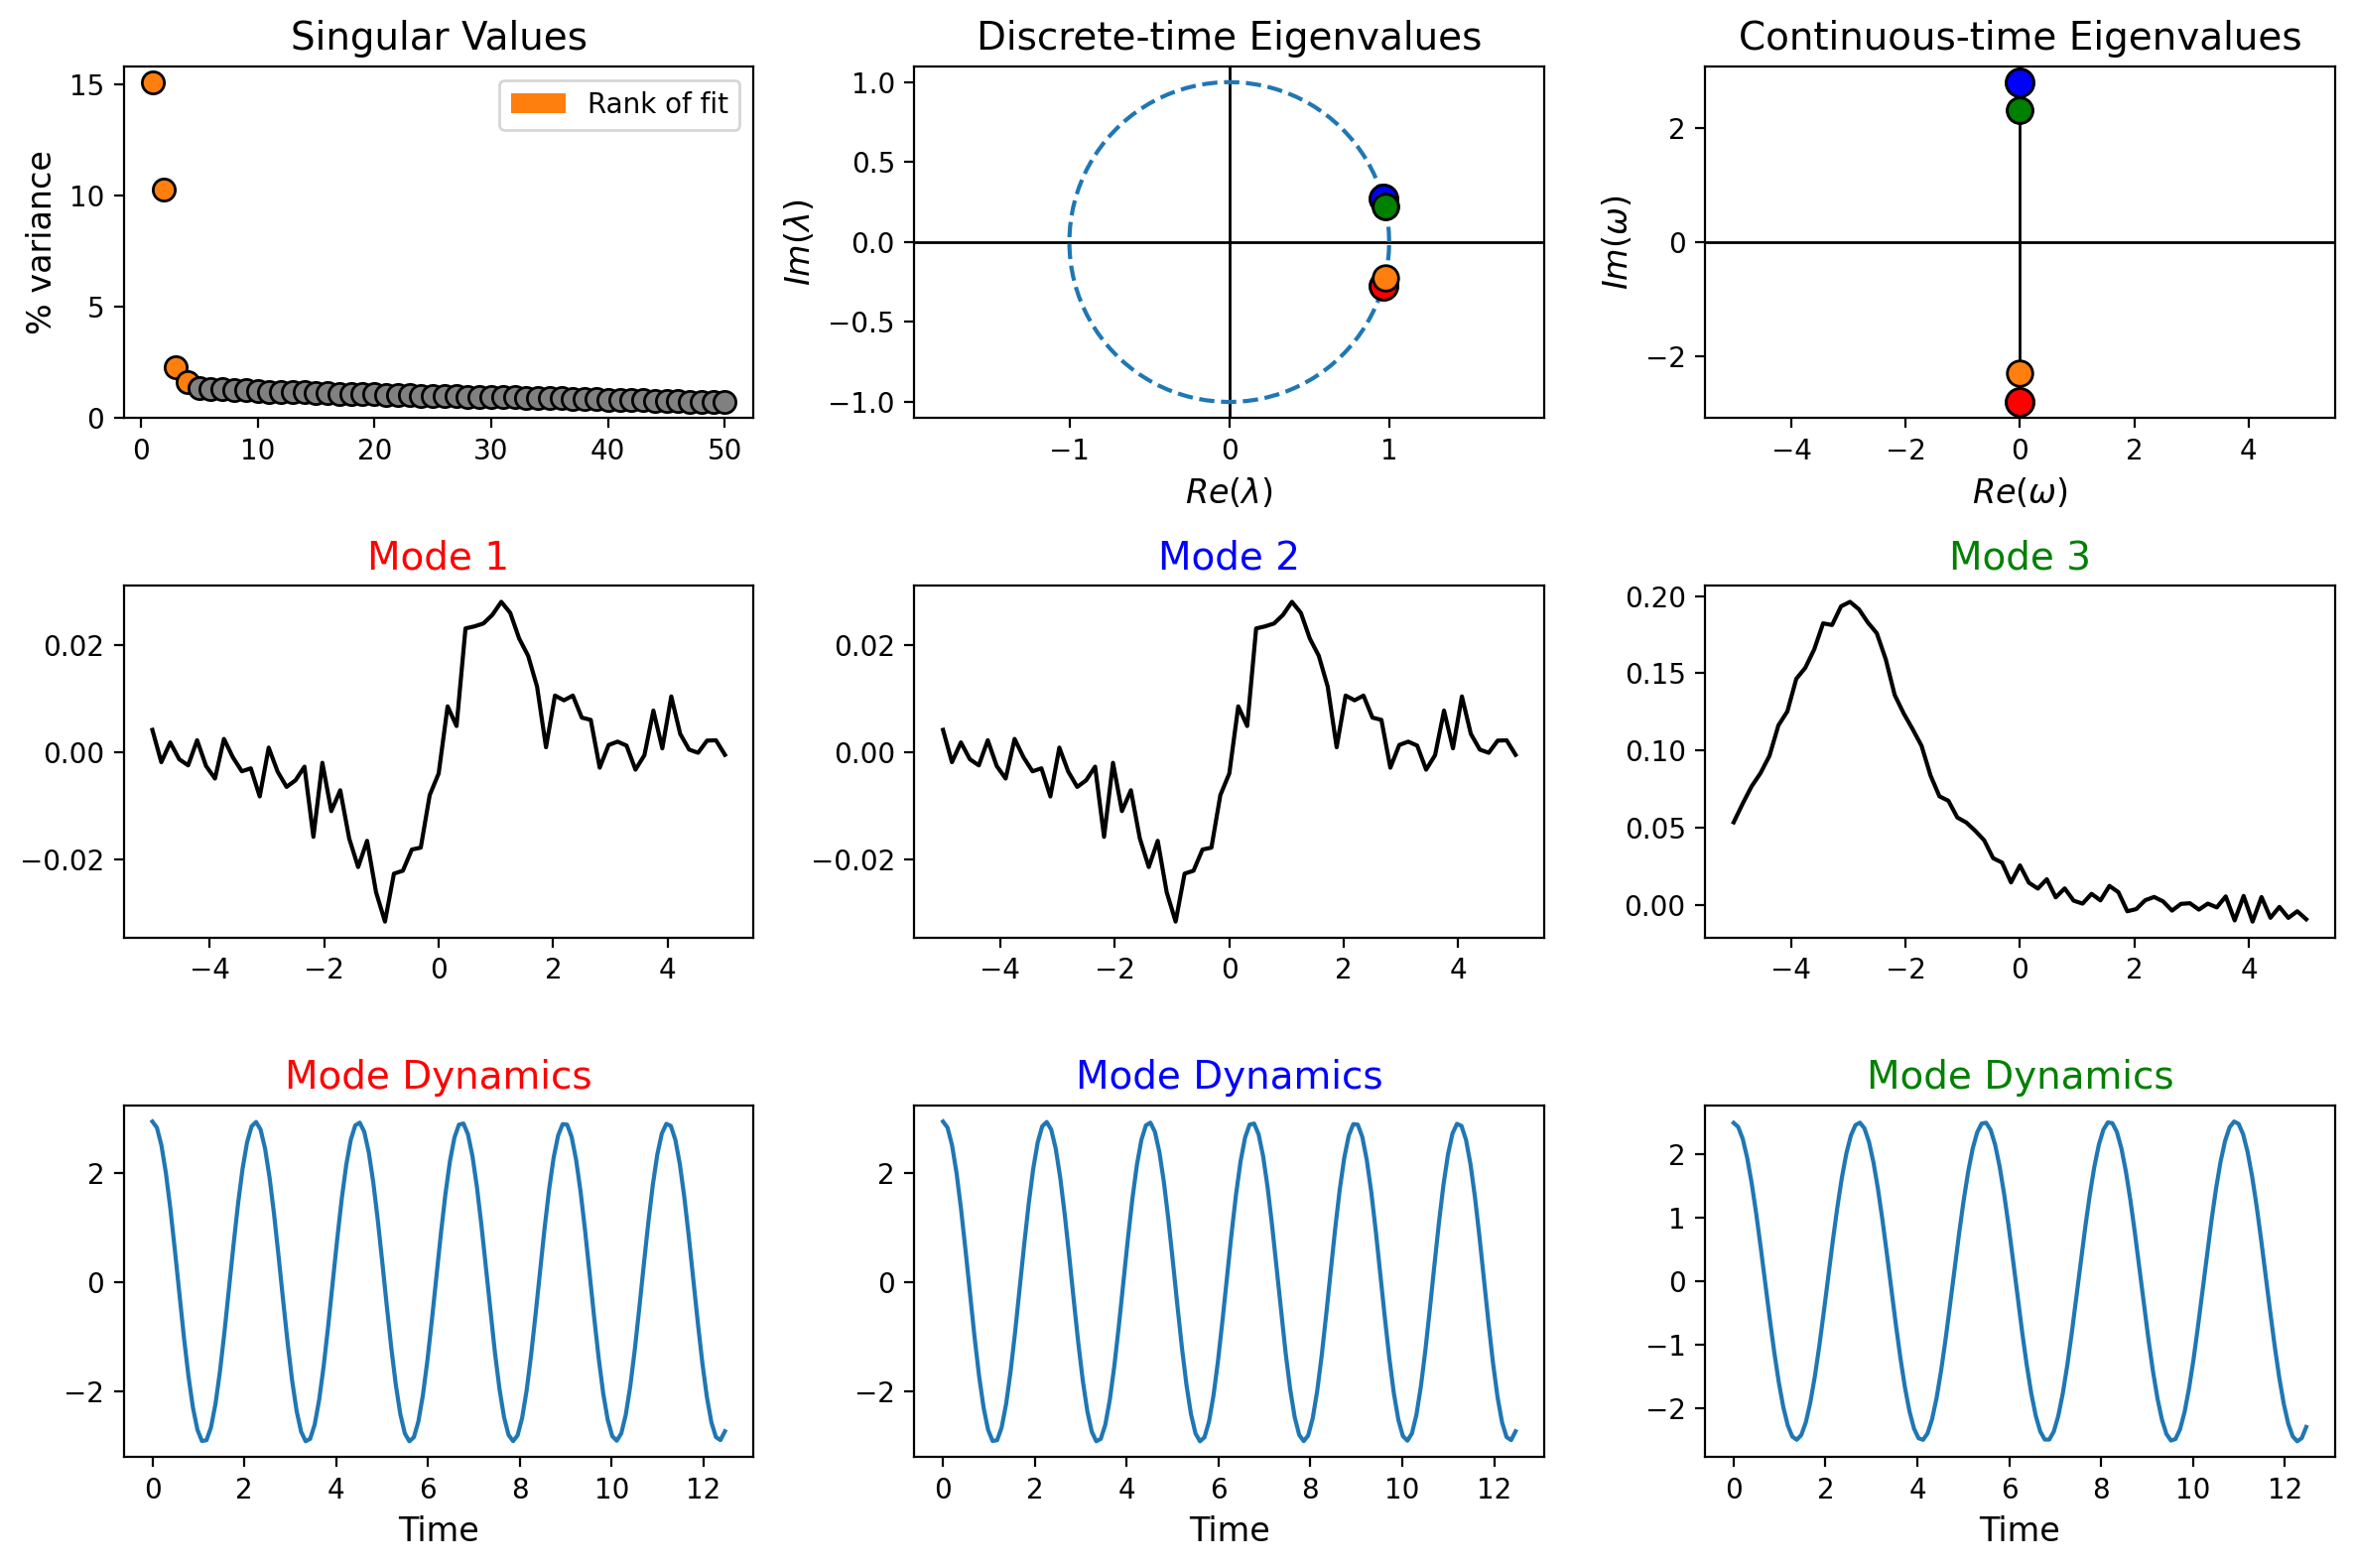

Frequencies (imaginary component): [-0.001+2.799j -0.001-2.799j  0.001+2.302j  0.001-2.302j]


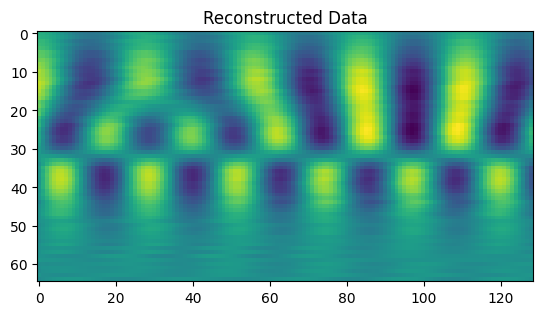

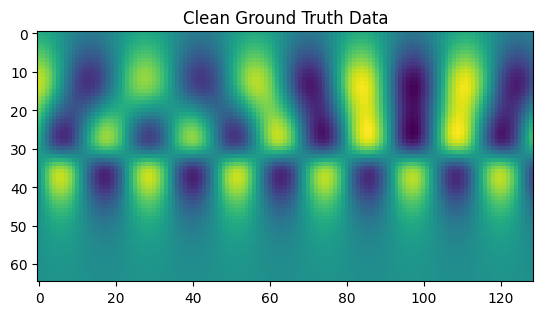

In [8]:
# Build the Optimized DMD model.
# num_trials=0 gives Optimized DMD, without bagging.
optdmd = BOPDMD(svd_rank=4, num_trials=0)

# Wrap the model with the preprocessing routine.
delay_optdmd = hankel_preprocessing(optdmd, d=d)

# Fit the model to the noisy data.
# Note: BOPDMD models need the data X and the times of data collection t for fitting.
# Hence if we apply time-delay, we must adjust the length of our time vector accordingly.
delay_t = t[: -d + 1]
delay_optdmd.fit(Xn.T, t=delay_t)

# Plot a summary of the DMD results.
plot_summary(delay_optdmd, x=x, d=d)

# Print computed eigenvalues (frequencies are given by imaginary components).
# Also plot the resulting data reconstruction.
print(
    f"Frequencies (imaginary component): {np.round(delay_optdmd.eigs, decimals=3)}"
)
plt.title("Reconstructed Data")
plt.imshow(delay_optdmd.reconstructed_data.real)
plt.show()
plt.title("Clean Ground Truth Data")
plt.imshow(X.T)
plt.show()

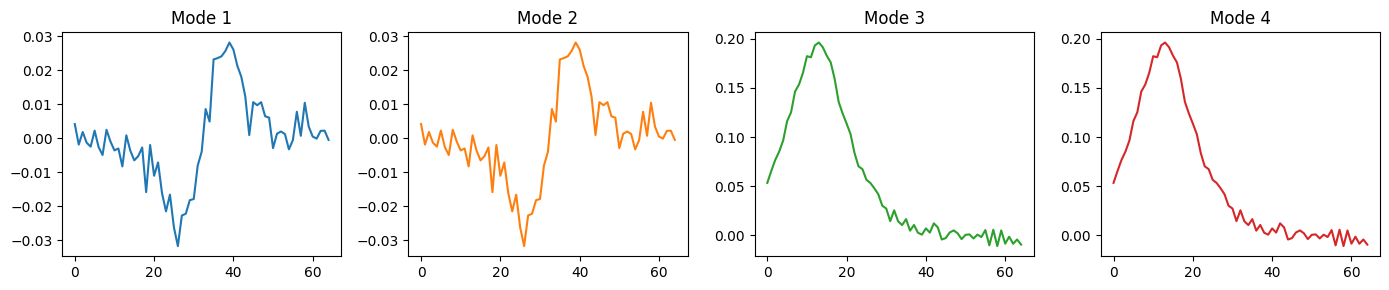

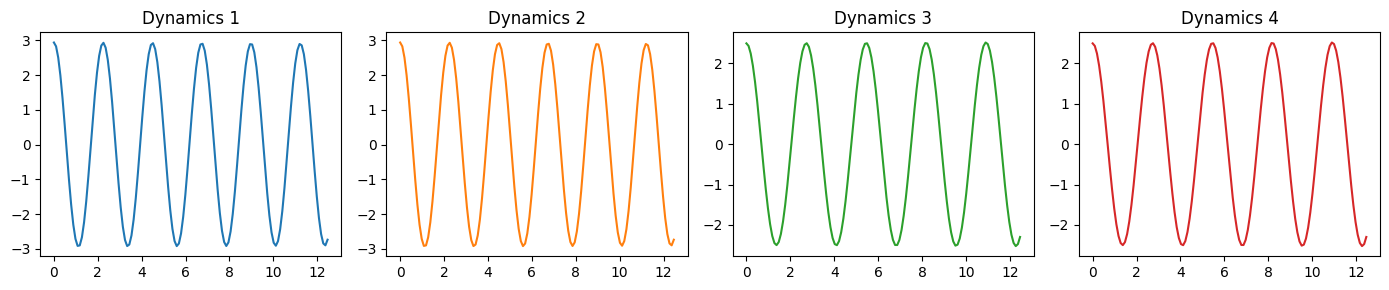

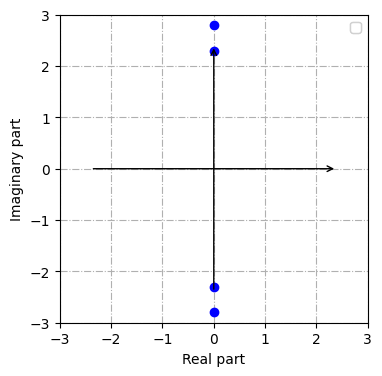

Computed amplitudes: [2.94  2.94  2.498 2.498]



In [9]:
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

# Plotting the modes individually...
plt.figure(figsize=(14, 3))
for i, mode in enumerate(delay_optdmd.modes.T):
    # Get the average across delays, since we used time-delay.
    mode = np.average(mode.reshape(d, len(mode) // d), axis=0)
    plt.subplot(1, len(delay_optdmd.modes.T), i + 1)
    plt.plot(mode.real, c=colors[i])
    plt.title(f"Mode {i + 1}")
plt.tight_layout()
plt.show()

# Plotting the dynamics individually...
plt.figure(figsize=(14, 3))
for i, dynamic in enumerate(delay_optdmd.dynamics):
    plt.subplot(1, len(delay_optdmd.dynamics), i + 1)
    plt.plot(delay_t, dynamic.real, c=colors[i])
    plt.title(f"Dynamics {i + 1}")
plt.tight_layout()
plt.show()

# Plot the eigenvalues.
plot_eigs(delay_optdmd, show_axes=True, show_unit_circle=False, figsize=(4, 4))

# Print the amplitudes.
print(f"Computed amplitudes: {np.round(delay_optdmd.amplitudes, decimals=3)}\n")

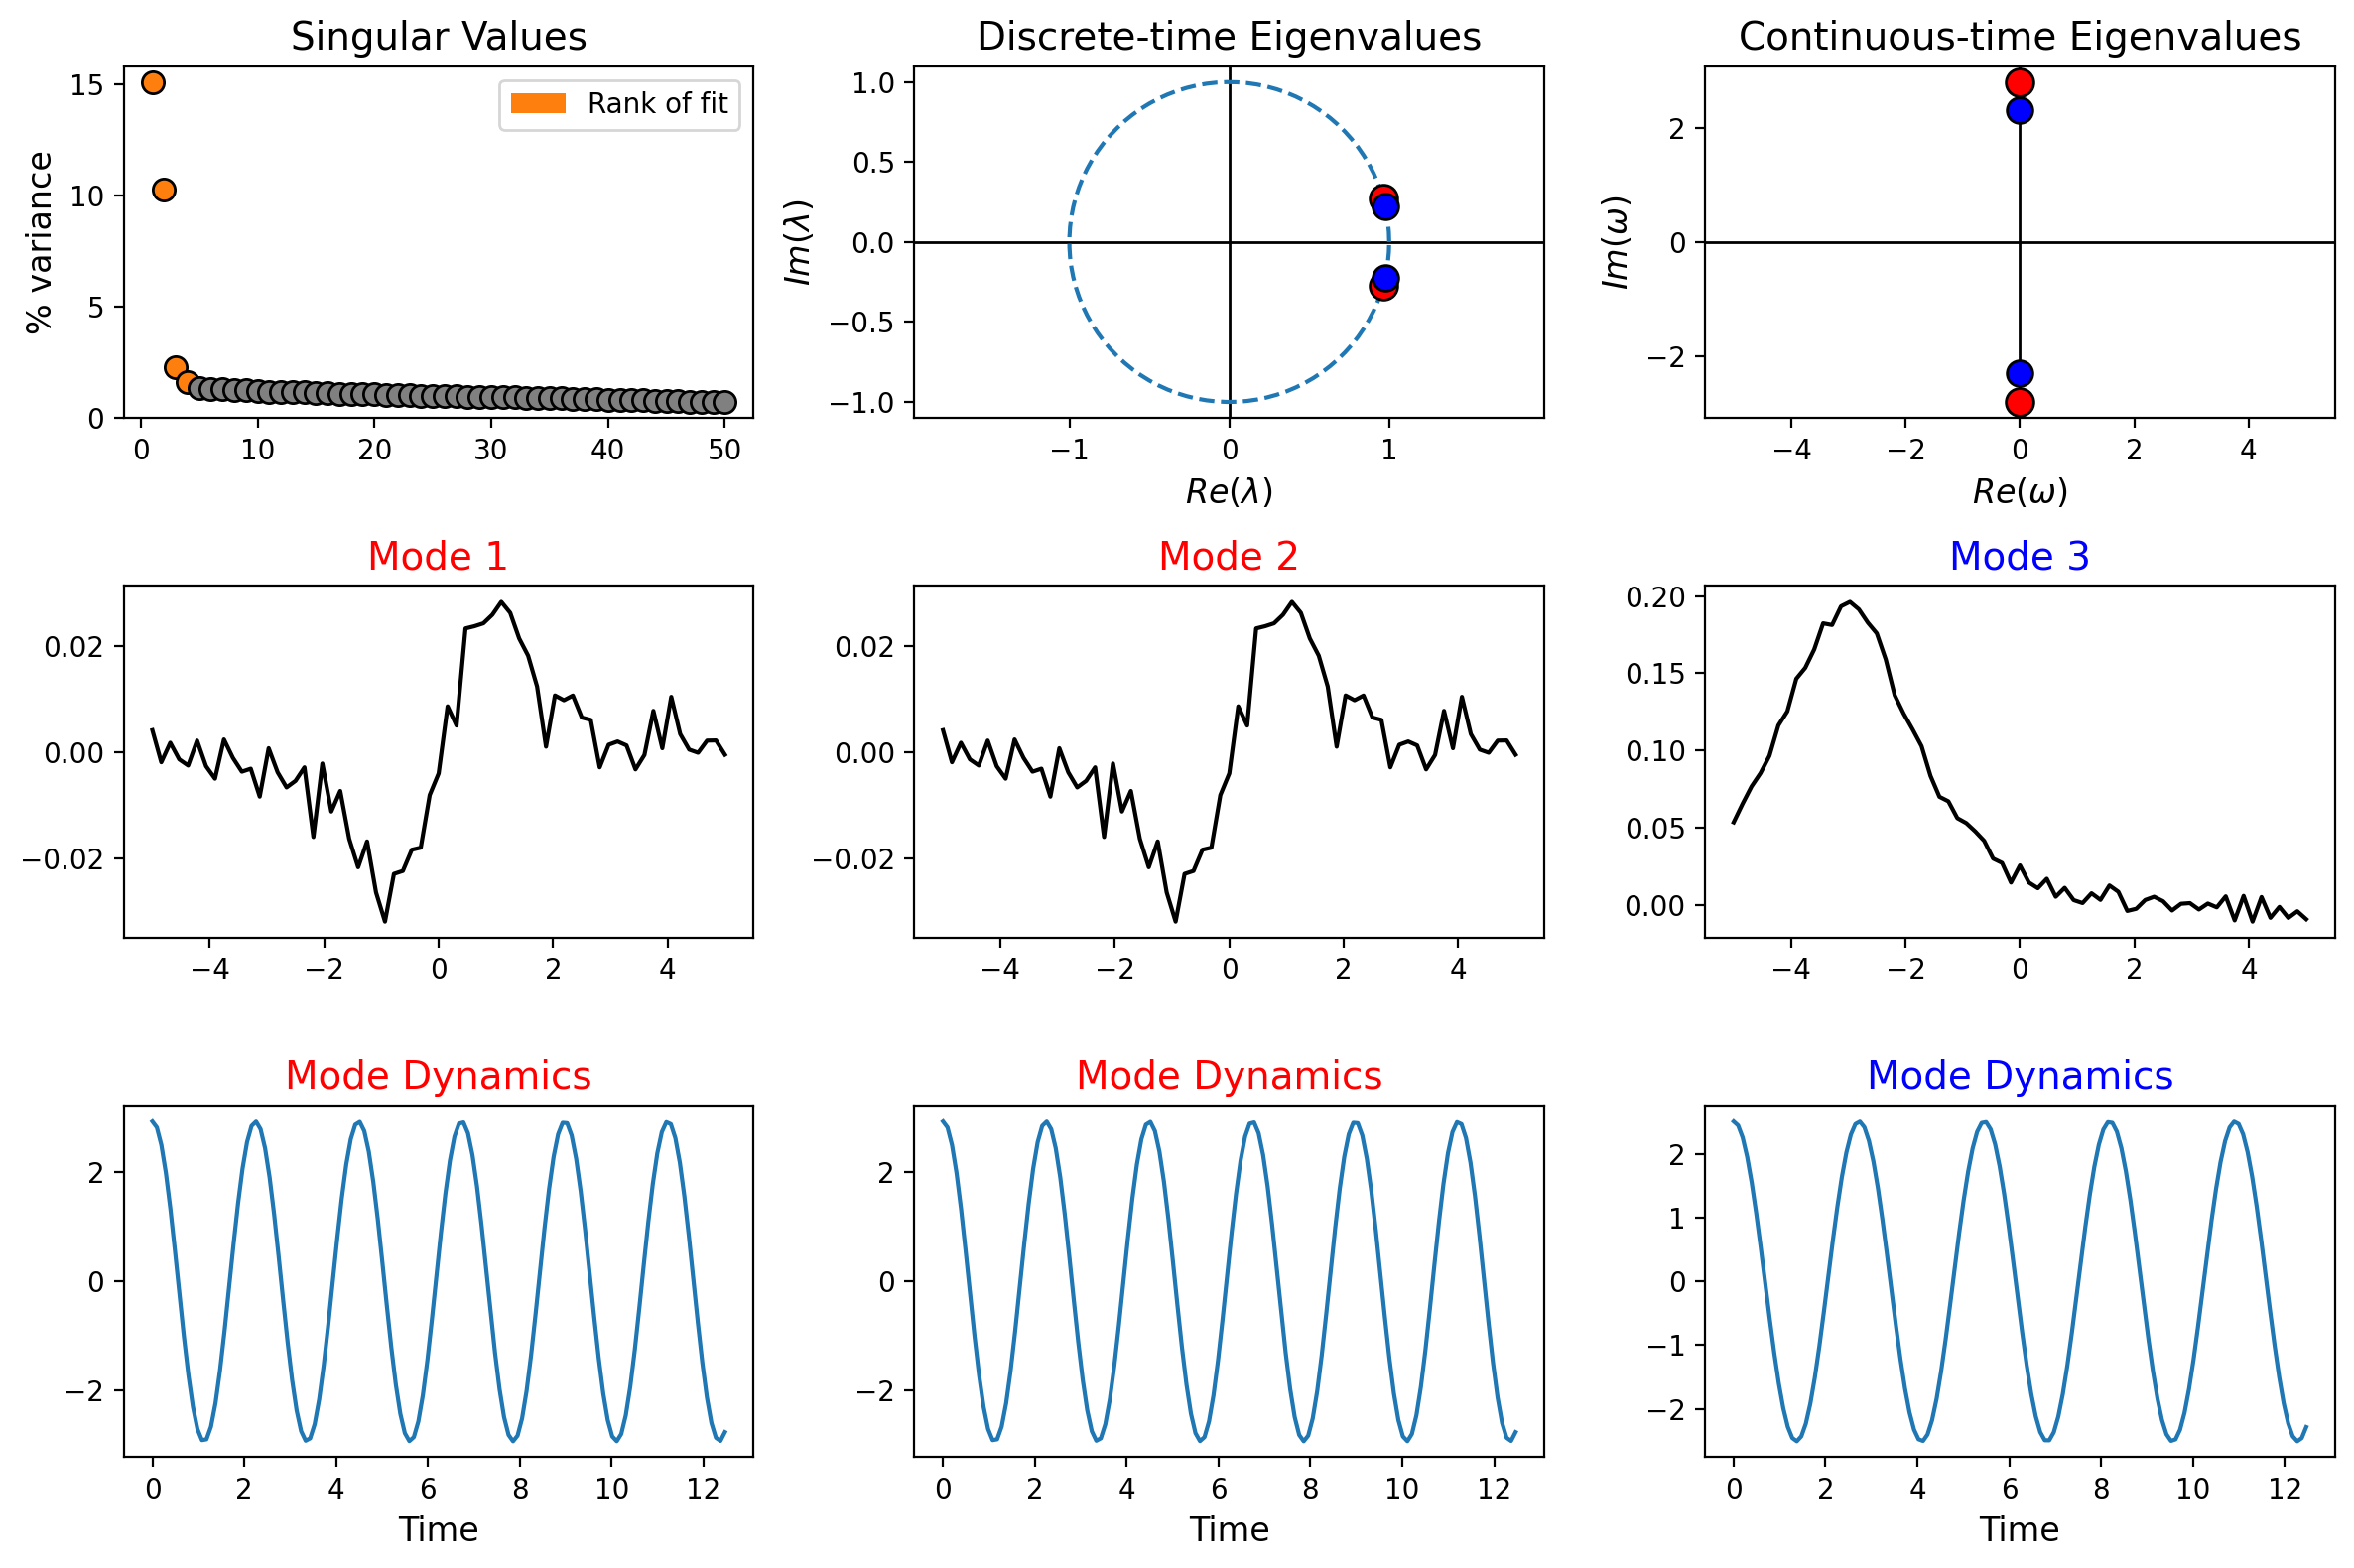

Frequencies (imaginary component): [ 0.+2.799j -0.-2.799j  0.+2.302j -0.-2.302j]


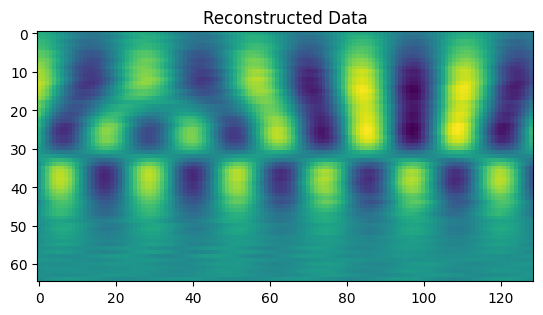

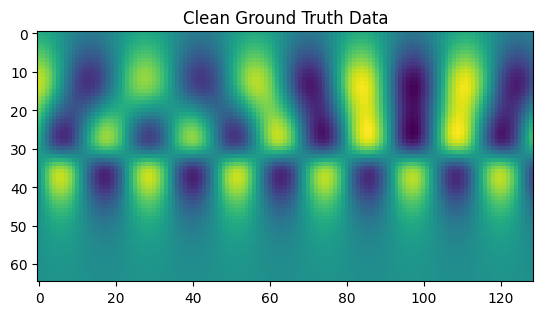

In [10]:
# CONSTRAINTS

# Stable: constrain to the left-half plane (no positive real parts to eigenvalues).
# bopdmd = BOPDMD(eig_constraints={"stable"})

# Imaginary: constrain to imaginary axis (no real parts to eigenvalues).
# bopdmd = BOPDMD(eig_constraints={"imag"})

# Stable + Conjugate: constrain to the left-half plane and as complex conjugates.
# bopdmd = BOPDMD(eig_constraints={"stable", "conjugate_pairs"})

# Imaginary + Conjugate: constrain to imaginary axis and as complex conjugates.
# bopdmd = BOPDMD(eig_constraints={"imag", "conjugate_pairs"})

optdmd = BOPDMD(
    svd_rank=4, num_trials=0, eig_constraints={"imag", "conjugate_pairs"}
)
delay_optdmd = hankel_preprocessing(optdmd, d=d)
delay_optdmd.fit(Xn.T, t=delay_t)
plot_summary(delay_optdmd, x=x, d=d)

print(
    f"Frequencies (imaginary component): {np.round(delay_optdmd.eigs, decimals=3)}"
)
plt.title("Reconstructed Data")
plt.imshow(delay_optdmd.reconstructed_data.real)
plt.show()
plt.title("Clean Ground Truth Data")
plt.imshow(X.T)
plt.show()


# **Why do we need time-delay?**

This is what happens without time-delay (using clean data and exact DMD):

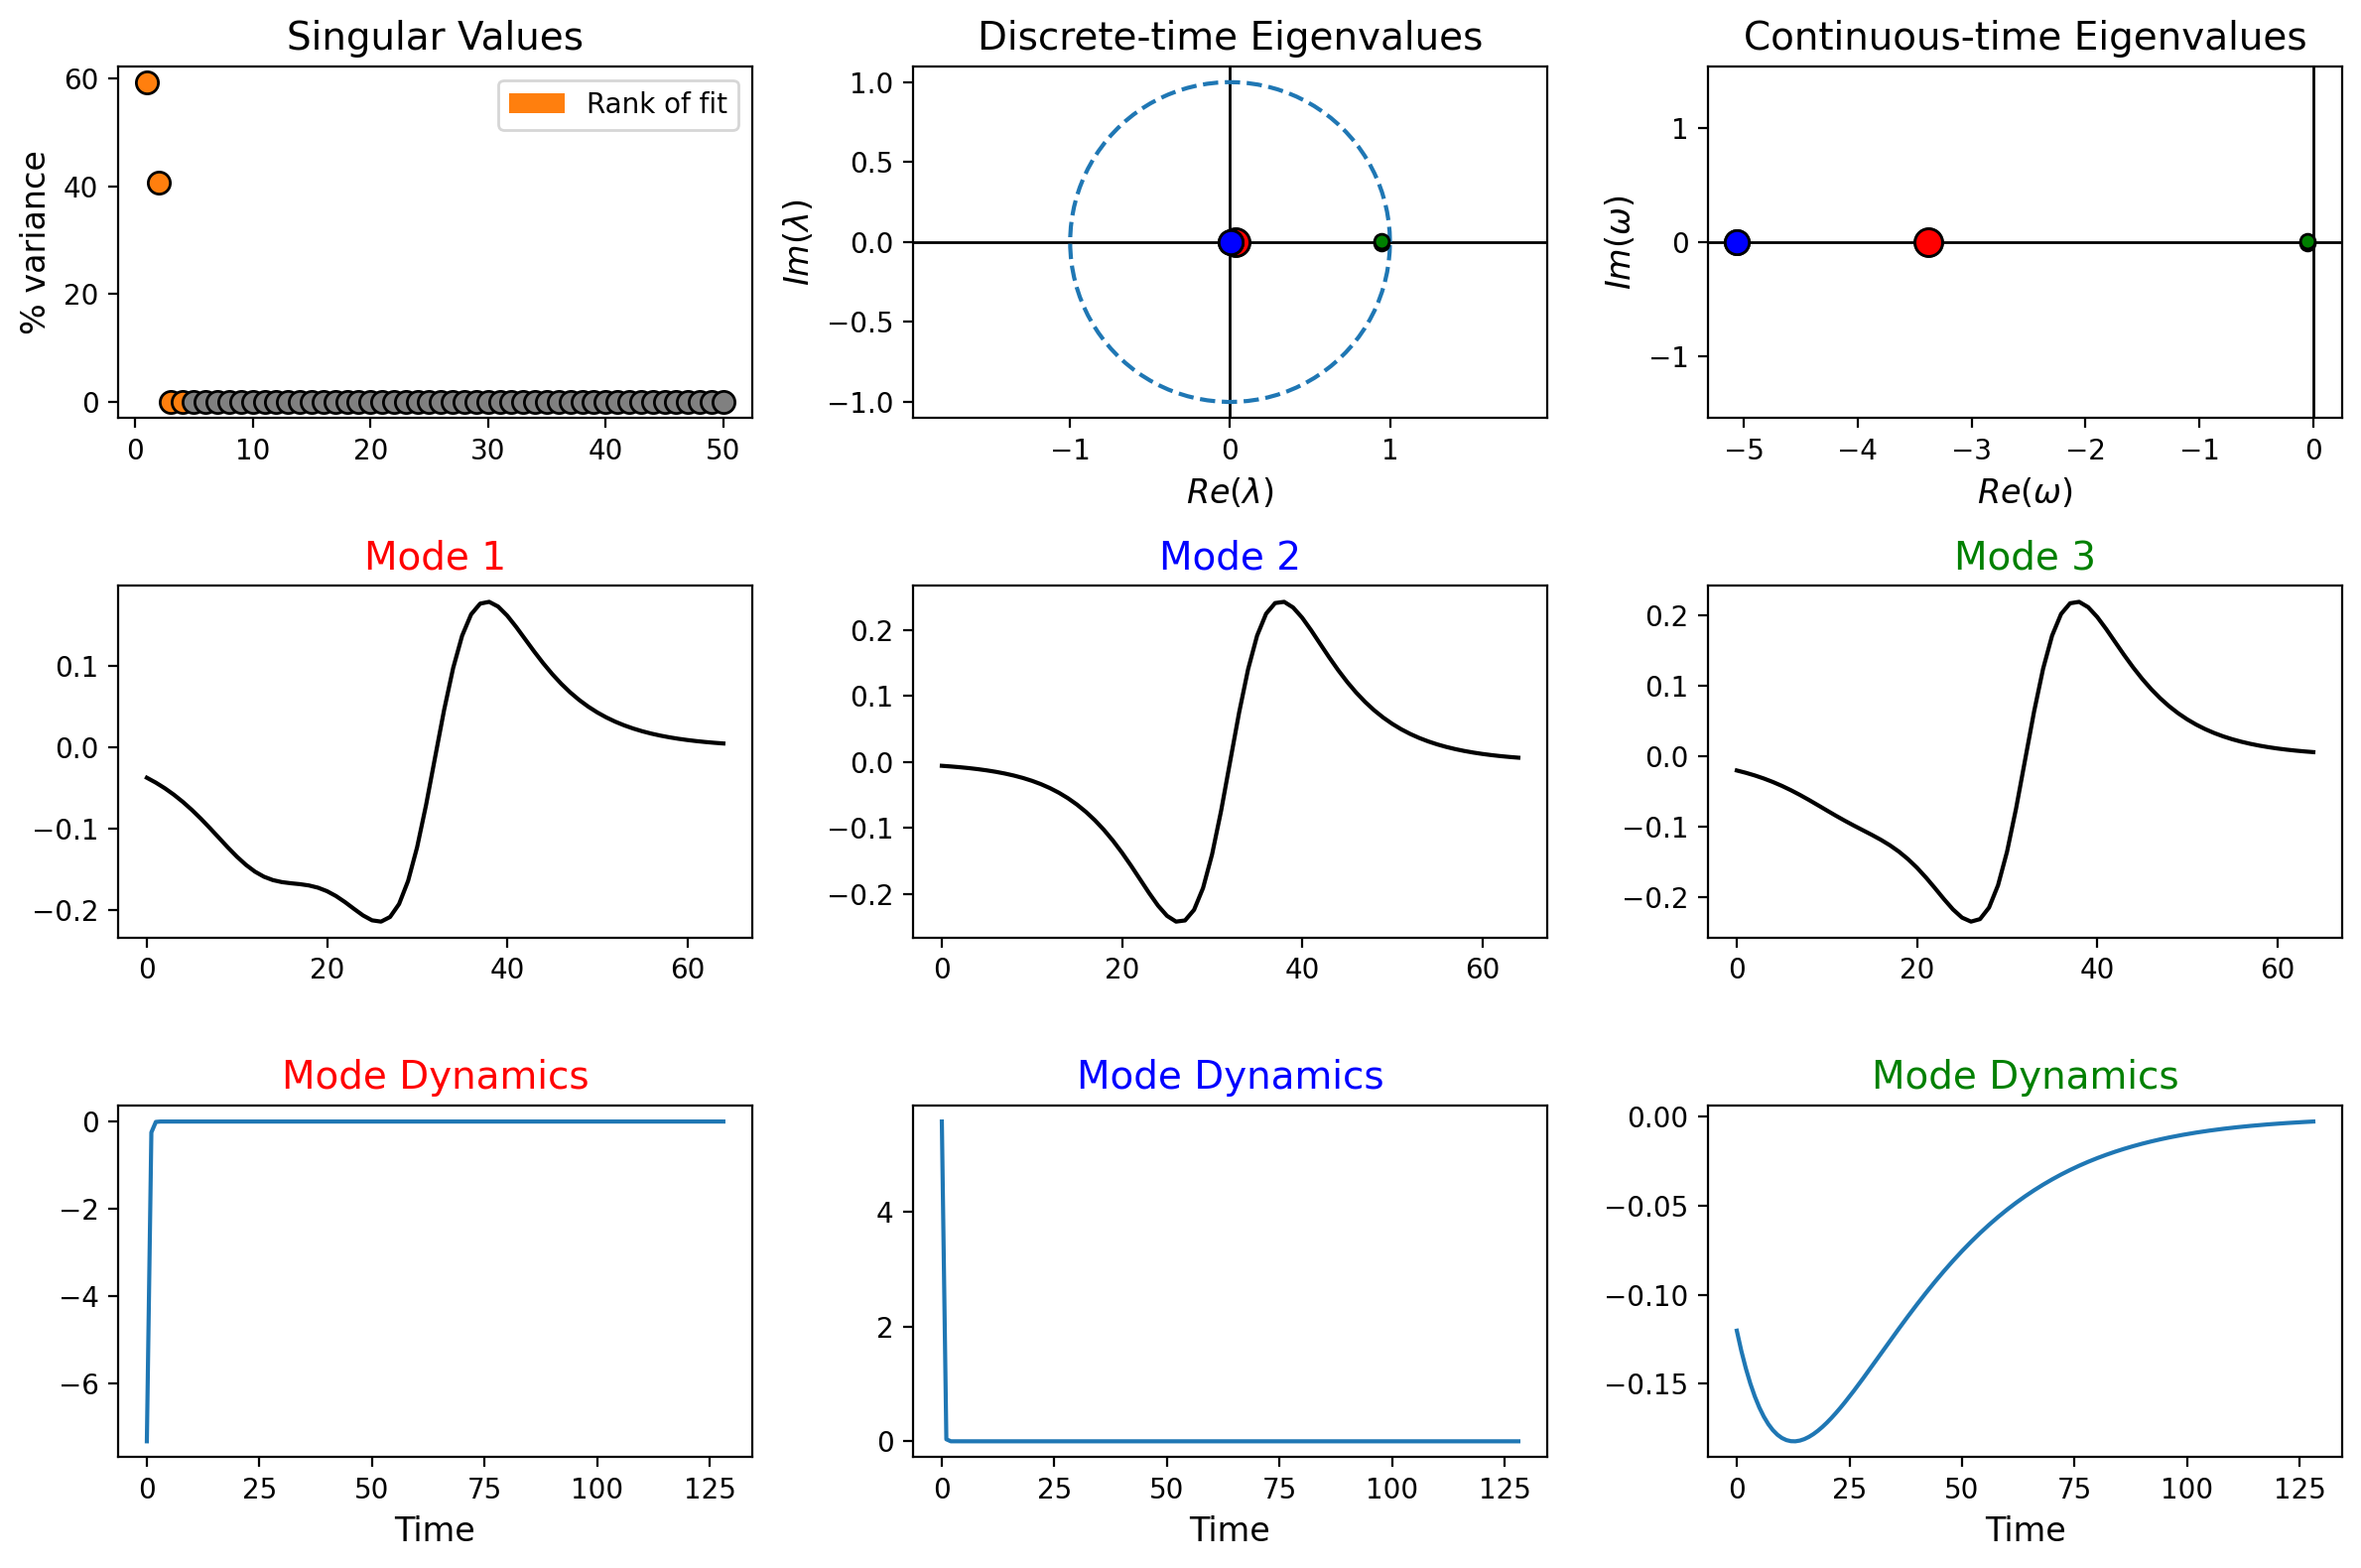

Frequencies (imaginary component): [ -0.525+0.09j  -0.525-0.09j -34.428+0.j   -51.553+0.j  ]


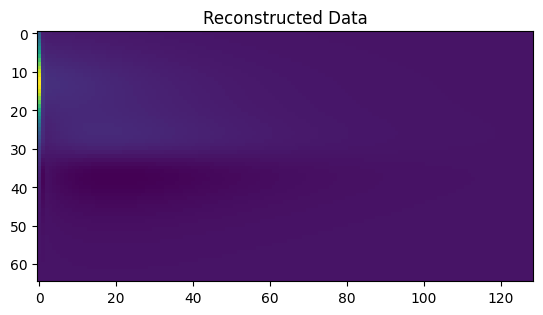

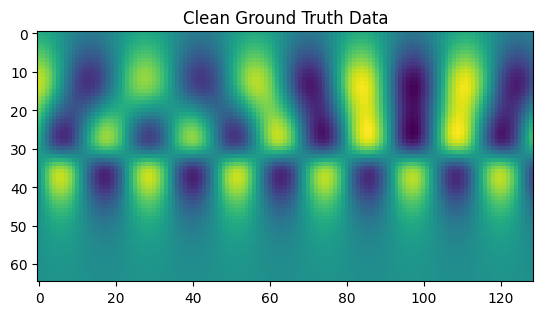

In [11]:
dmd = DMD(svd_rank=4)
dmd.fit(X.T)
plot_summary(dmd)

print(
    f"Frequencies (imaginary component): {np.round(np.log(dmd.eigs) / dt, decimals=3)}"
)
plt.title("Reconstructed Data")
plt.imshow(dmd.reconstructed_data.real)
plt.show()
plt.title("Clean Ground Truth Data")
plt.imshow(X.T)
plt.show()

# **Why do we use BOP-DMD?**
**This is what happens when we use exact DMD instead of BOP-DMD:**

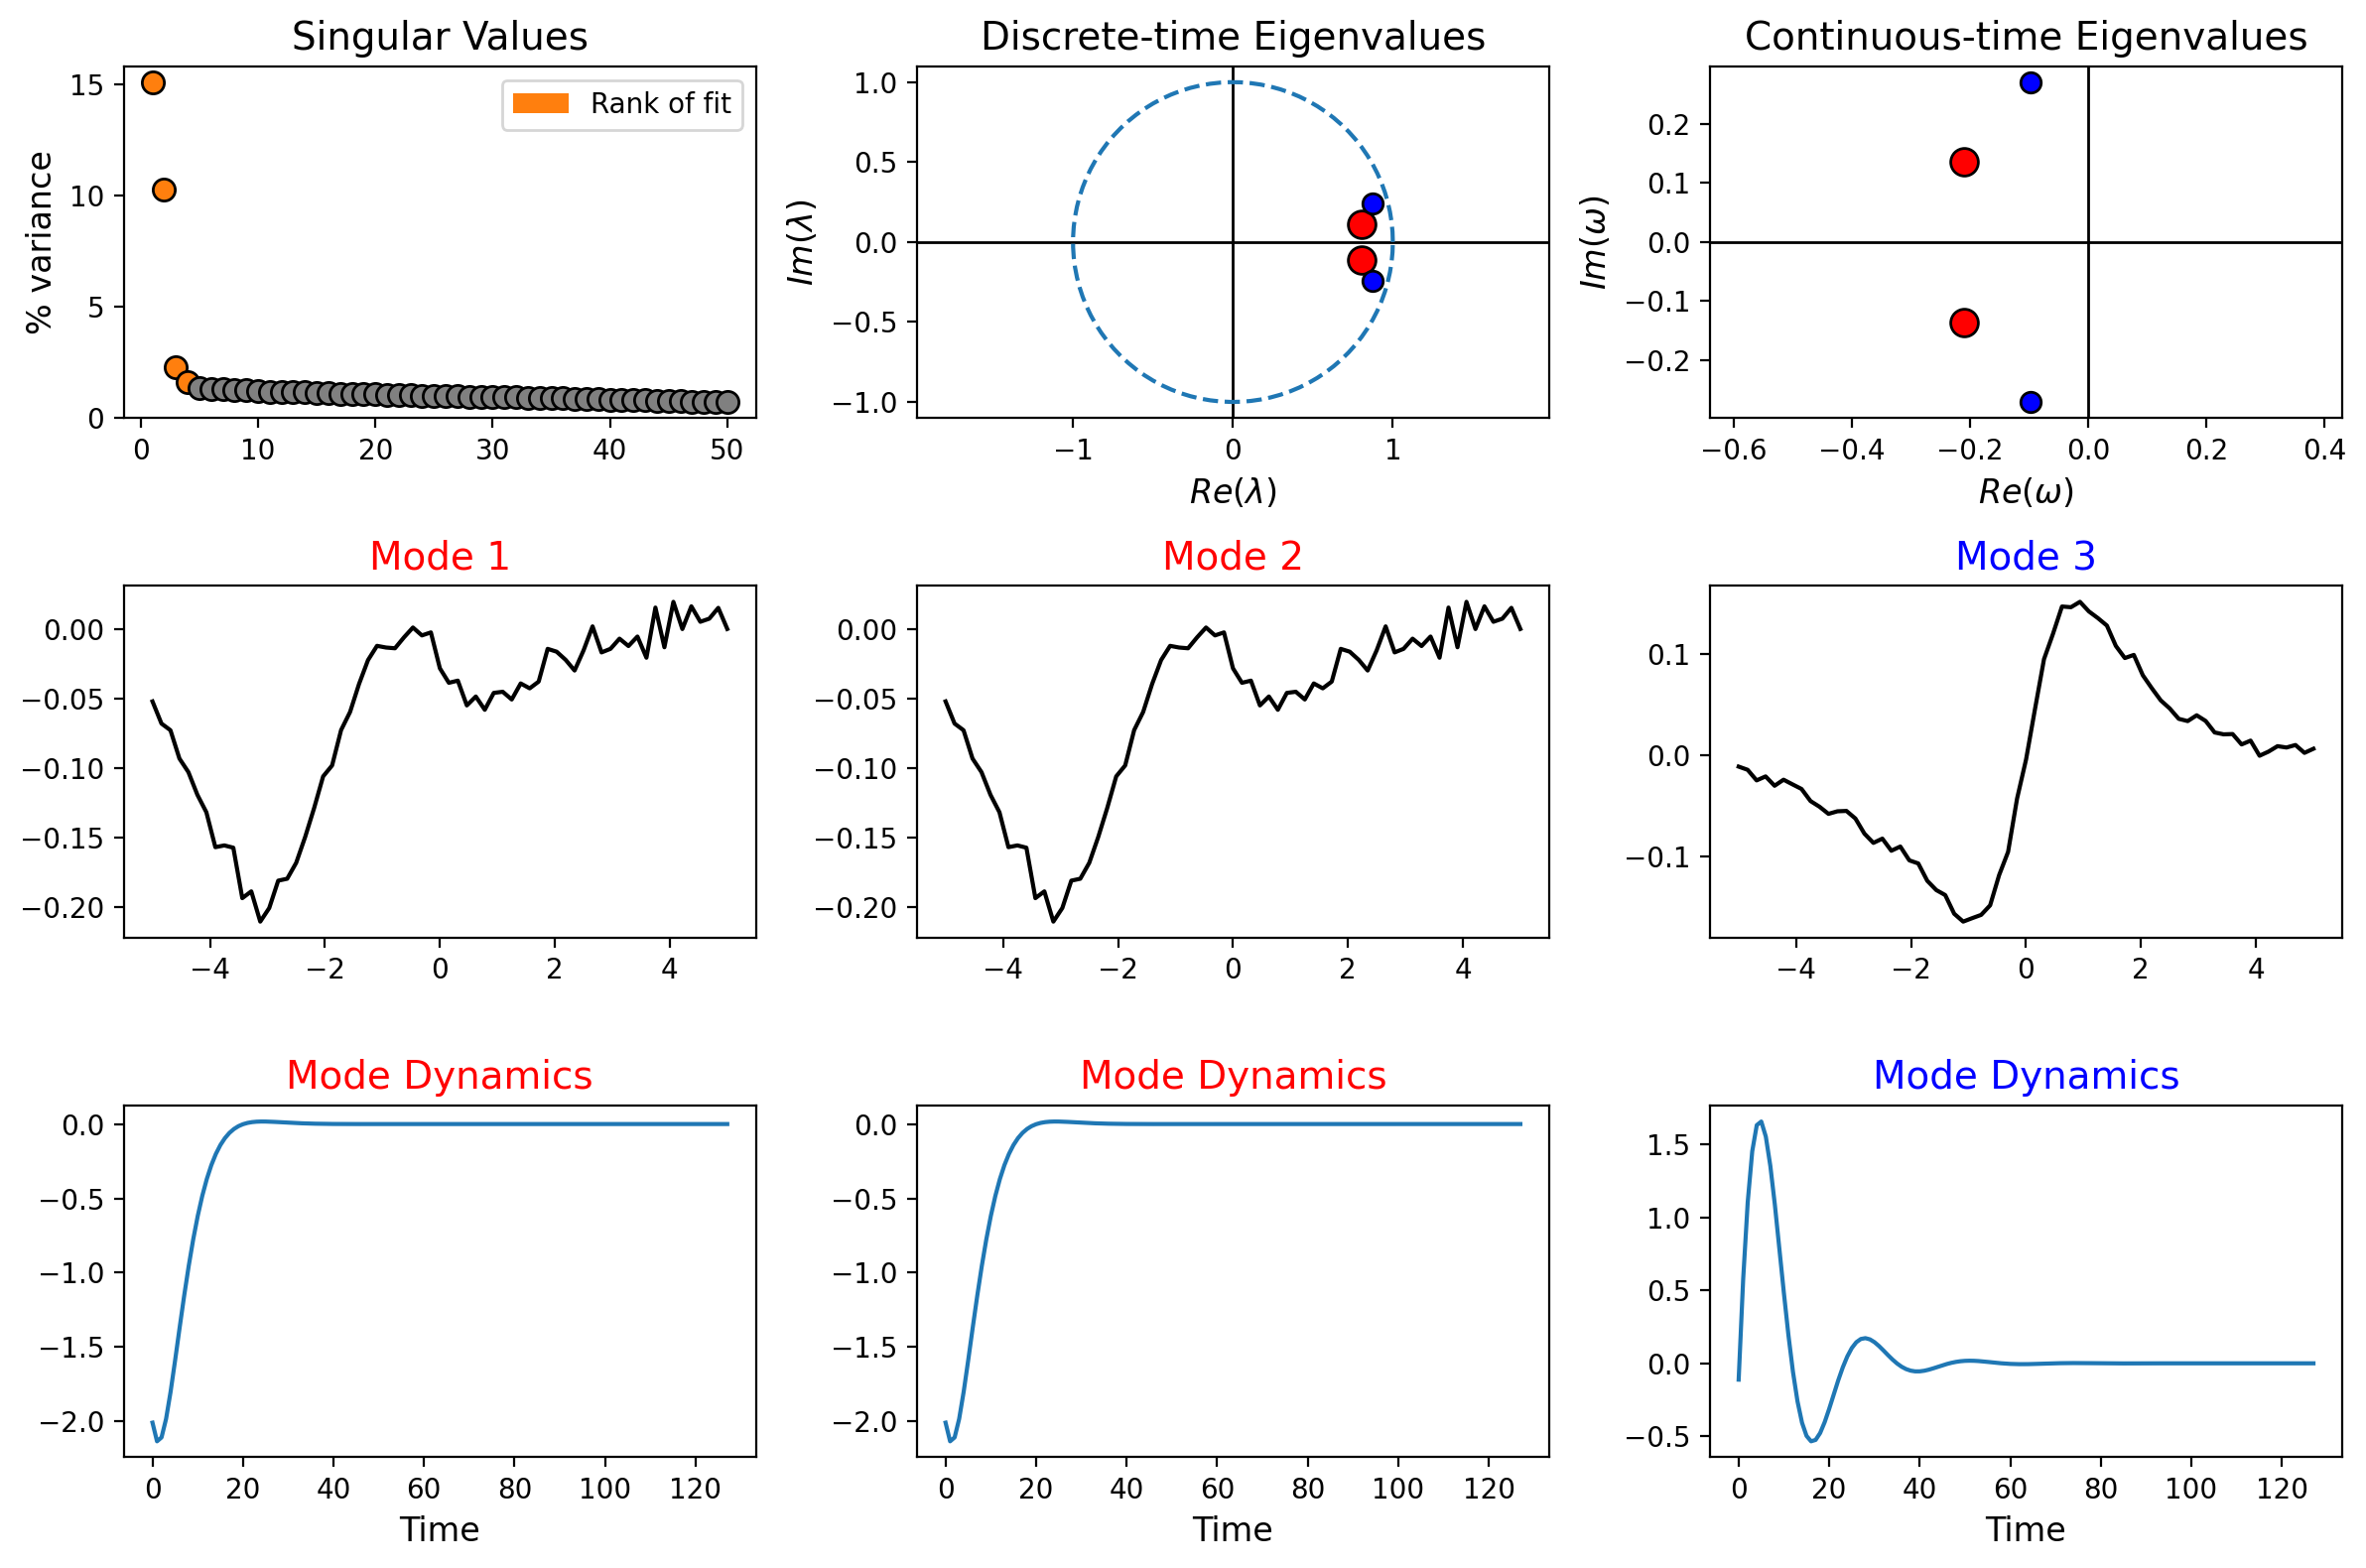

Frequencies (imaginary component): [-0.995+2.758j -0.995-2.758j -2.138+1.388j -2.138-1.388j]


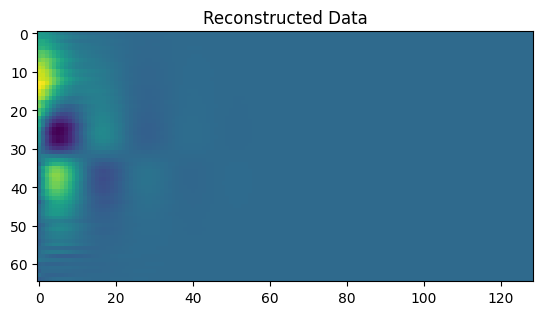

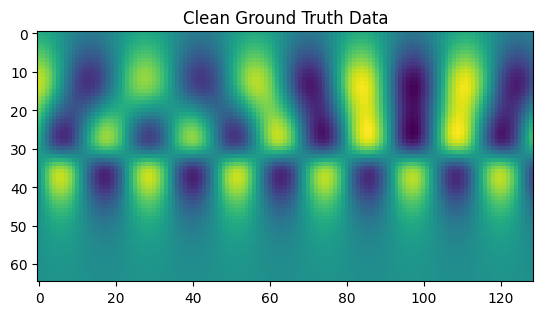

In [12]:
dmd = DMD(svd_rank=4)
delay_dmd = hankel_preprocessing(dmd, d=d)
delay_dmd.fit(Xn.T)
plot_summary(delay_dmd, x=x, d=d)

print(
    f"Frequencies (imaginary component): {np.round(np.log(delay_dmd.eigs) / dt, decimals=3)}"
)
plt.title("Reconstructed Data")
plt.imshow(delay_dmd.reconstructed_data.real)
plt.show()
plt.title("Clean Ground Truth Data")
plt.imshow(X.T)
plt.show()